In [1]:
import pandas as pd
from pandas.io.json import build_table_schema
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import scipy as sp
import os
import xgboost as xgb
import visualization as vis
import matplotlib.pyplot as plt
import matplotlib
import plot_improper_processing as plt_imp
import time
from operator import itemgetter
import seaborn as sns
%matplotlib inline

DIR_PATH = './'

In [2]:
traindata  = pd.read_csv("./data/clean_train_only_complete_cols_chase.csv")
testdata = pd.read_csv("./data/clean_test_only_complete_cols_chase.csv")
print len(traindata.columns.values)
print 40 * '*'
print len(testdata.columns.values)

247
****************************************
246


In [3]:
traindata.loc[:, 'log_price_doc'] = np.log(traindata['price_doc'] + 1)

traindata.loc[:, 'year'] =  traindata.loc[:,'timestamp'].apply(lambda x: x[0:4])
traindata.loc[:, 'month'] =  traindata.loc[:, 'timestamp'].apply(lambda x: x[5:7])
testdata.loc[:, 'year'] = testdata.loc[:, 'timestamp'].apply(lambda x: x[0:4])
testdata.loc[:, 'month'] = testdata.loc[:, 'timestamp'].apply(lambda x: x[0:4])

In [4]:
from sklearn import model_selection, preprocessing
for f in testdata.columns:
    if testdata[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(testdata[f].values.astype('str')))
        testdata[f] = lbl.transform(list(testdata[f].values.astype('str')))

timestamp
product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
okurg_district
year
month


In [5]:
from sklearn import model_selection, preprocessing
for f in traindata.columns:
    if traindata[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(traindata[f].values.astype('str')))
        traindata[f] = lbl.transform(list(traindata[f].values.astype('str')))

timestamp
product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology
okurg_district
year
month


In [6]:
feature_cols = ['full_sq', 'life_sq', 'floor', 'max_floor', 'kitch_sq',
               'kindergarten_km', 'school_km', 'park_km', 'green_zone_km', 'industrial_km',
               'metro_min_avto', 'railroad_km','public_transport_station_km','sub_area',
               'swim_pool_km','cemetery_km','public_healthcare_km','fitness_km','radiation_km',
               'year','month']
target_column  = ['log_price_doc']

In [7]:
X_data =  traindata[feature_cols]
y_data =  traindata[target_column]
X_testdata = testdata[feature_cols] # note this only for Kaggle and there is no y_testdata

In [8]:
X_train = X_data.values
Y_train = y_data.values
X_test = X_testdata.values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(29096, 21)
(29096, 1)
(7662, 21)


# Linear Regression (Information Leakage) 

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, StandardScaler 

In [10]:
xRid_train, xRid_test, yRid_train, yRid_test = model_selection.train_test_split(X_train,Y_train,random_state=42)

In [11]:
stdScaler = StandardScaler()
stdScaler.fit(xRid_train)
xRid_train_scaled = stdScaler.transform(xRid_train)
xRid_test_scaled = stdScaler.transform(xRid_test)

In [12]:
param_grid = {'alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid =  GridSearchCV(Ridge(), param_grid, cv =5)
grid.fit(xRid_train_scaled, yRid_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
print("Best parameters: {}".format(grid.best_params_))
print("Best cross-validation score: {:.3f}".format(grid.best_score_))

Best parameters: {'alpha': 1}
Best cross-validation score: 0.513


In [14]:
print("The R^2 on the training set:  {:.6f}".format(grid.score(xRid_train_scaled, yRid_train)))
print("The R^2 on the test set:  {:.6f}".format(grid.score(xRid_test_scaled, yRid_test)))

The R^2 on the training set:  0.514034
The R^2 on the test set:  0.535695


In [15]:
from sklearn.pipeline import make_pipeline 
pipe  =  make_pipeline(StandardScaler(), Ridge())
param_grid = {'ridge__alpha': [100,10,1,0.1,0.01,0.001,0.0001,0]}
grid_pipe =  GridSearchCV(pipe, param_grid, cv=5)
grid_pipe.fit(xRid_train, yRid_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
print("Best parameters: {}".format(grid_pipe.best_params_))
print("Best Cross-validation RMS: {:.3f}".format(grid_pipe.best_score_))
#print("Test Best Score: {:.3f}".format(grid.score(X_test, Y_test)))


Best parameters: {'ridge__alpha': 1}
Best Cross-validation RMS: 0.513


In [17]:
print("The R^2 on the training set:  {:.6f}".format(grid_pipe.score(xRid_train_scaled, yRid_train)))
print("The R^2 on the test set:  {:.6f}".format(grid_pipe.score(xRid_test_scaled, yRid_test)))

The R^2 on the training set:  -2.090784
The R^2 on the test set:  -2.057073


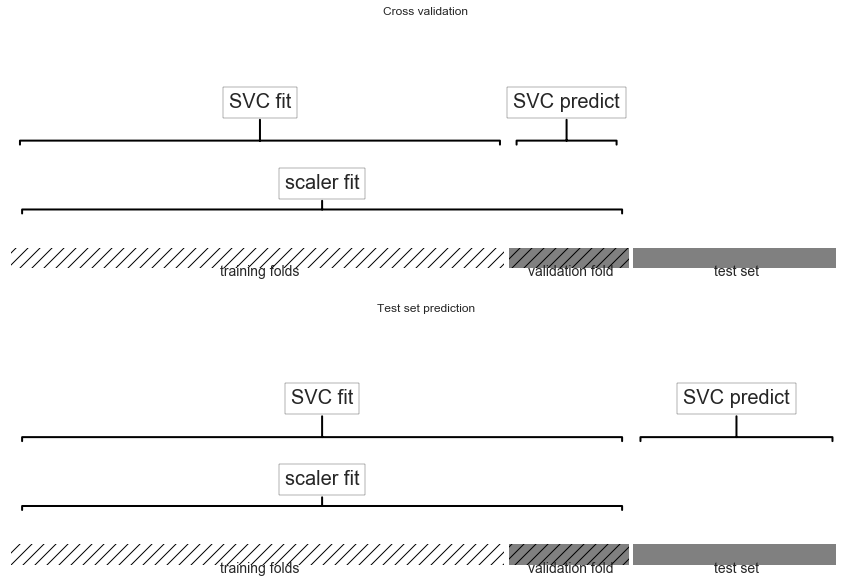

In [19]:
plt_imp.plot_improper_processing()

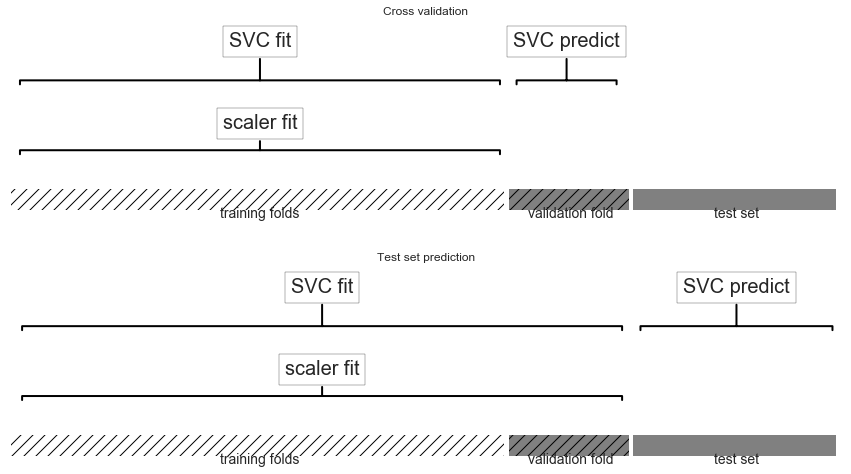

In [21]:
plt_imp.plot_proper_processing()